In [66]:
import numpy as np
import pandas as pd
from threading import Thread
import time
import matplotlib.pyplot as plt
import json
import os
from bs4 import BeautifulSoup
import torch
# from torch import nn
# from torch.utils.data import DataLoader, Dataset
# from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

import seaborn as sns
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.svm import SVC
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#nltk.download('stopwords')

Data Cleaning and Preparation

In [67]:
# Load the csv file containing style data
styles_df = pd.read_csv('styles.csv', on_bad_lines='skip')

In [68]:
# Display the dimensions
print(styles_df.shape)
# View data
styles_df.head()

(44424, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [69]:
# View data types
styles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


masterCategory
Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64


<Axes: xlabel='masterCategory'>

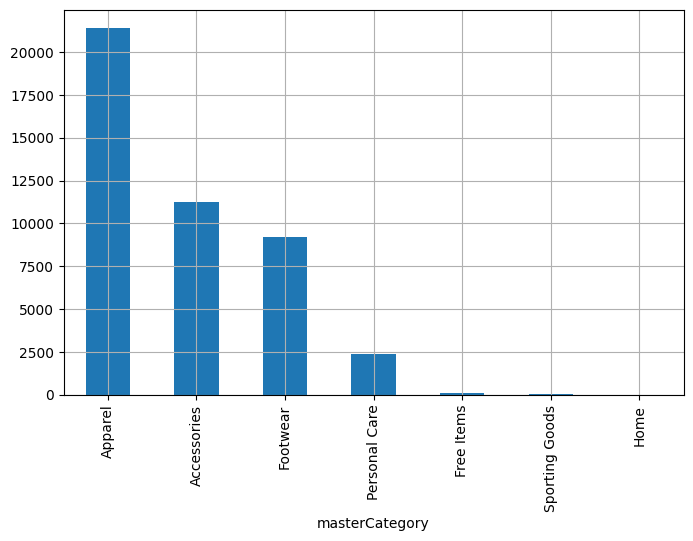

In [70]:
# Find out how much of each category there is originally
counts = styles_df['masterCategory'].value_counts()
print(counts)
counts.plot(kind='bar', legend=False, grid=True, figsize=(8, 5))

In [71]:
# Check the frequency of null values in each column
styles_df.isnull().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [72]:
# Check how many null values per row
styles_df.isnull().sum(axis=1).sort_values(ascending = False)

17639    3
14291    3
23484    3
37531    3
40675    3
        ..
44419    0
44420    0
44421    0
44422    0
44407    0
Length: 44424, dtype: int64

In [73]:
#delete rows with missing variables
styles_df = styles_df.dropna()

(44077, 10)
masterCategory
Apparel           21366
Accessories       11244
Footwear           9197
Personal Care      2139
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64


<Axes: xlabel='masterCategory'>

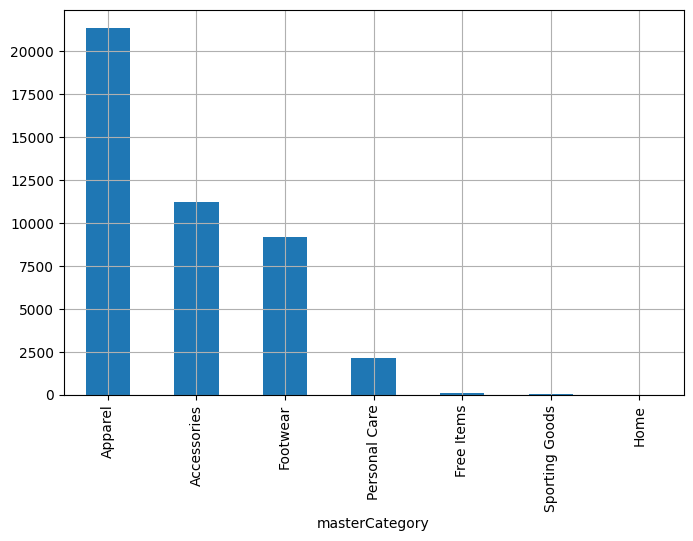

In [74]:
# Display the dimensions
print(styles_df.shape)
# Find out how much of each category there is after removing things with 3 or more missing variables
counts = styles_df['masterCategory'].value_counts()
print(counts)
counts.plot(kind='bar', legend=False, grid=True, figsize=(8, 5))

In [75]:
# Limit the data to 2016 onward to keep the data more current
styles_df = styles_df[(styles_df['year'] >= 2016)]
# Reset the indices once rows are removed
styles_df.reset_index(drop=True, inplace=True)

masterCategory
Accessories      4611
Personal Care    2139
Apparel          1767
Footwear          504
Free Items         63
Name: count, dtype: int64


<Axes: xlabel='masterCategory'>

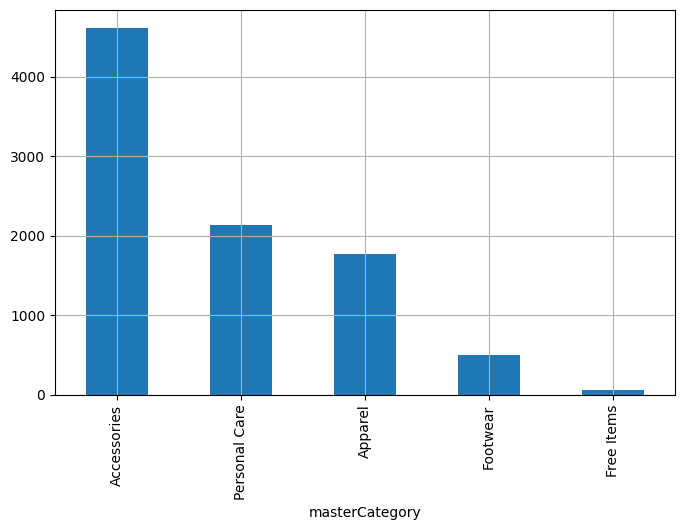

In [76]:
# Find out how much of each category there is after only looking beyond 2016
counts = styles_df['masterCategory'].value_counts()
print(counts)
counts.plot(kind='bar', legend=False, grid=True, figsize=(8, 5))

In [77]:
only_accessories = styles_df[styles_df['masterCategory'] == 'Accessories']
random_accessories = only_accessories.sample(2500)
styles_df = styles_df.drop(random_accessories.index)

masterCategory
Personal Care    2139
Accessories      2111
Apparel          1767
Footwear          504
Free Items         63
Name: count, dtype: int64


<Axes: xlabel='masterCategory'>

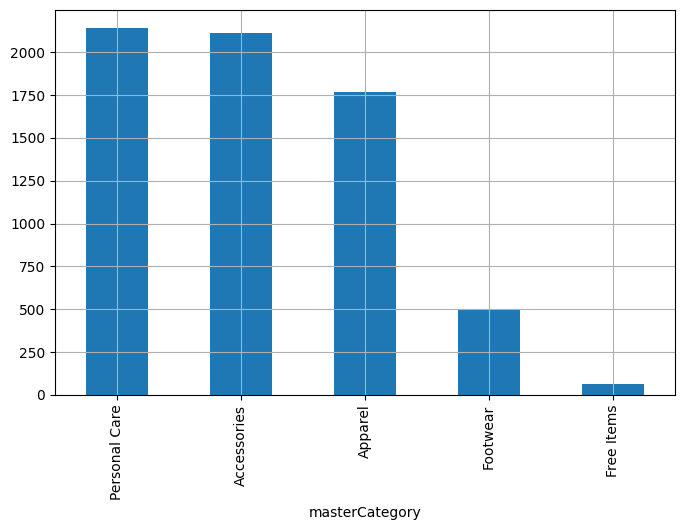

In [78]:
# Check the bar plots now that they have been evened out
counts = styles_df['masterCategory'].value_counts()
print(counts)
counts.plot(kind='bar', legend=False, grid=True, figsize=(8, 5))

In [79]:
# Create a new column 'category_id' with encoded categories 
styles_df['category_id'] = styles_df['masterCategory'].factorize()[0]
category_id_df = styles_df[['masterCategory', 'category_id']].drop_duplicates()

category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'masterCategory']].values)

styles_df = styles_df[styles_df['masterCategory'] != 'Home']

# New dataframe
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,category_id
0,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,0
3,51832,Women,Apparel,Innerwear,Bra,Beige,Summer,2016.0,Casual,Bwitch Beige Full-Coverage Bra BW335,1
5,18461,Men,Personal Care,Fragrance,Deodorant,White,Spring,2017.0,Casual,David Beckham Signature Men Deos,2
6,56019,Women,Personal Care,Lips,Lipstick,Brown,Spring,2017.0,Casual,Colorbar Soft Touch Show Stopper Copper Lipsti...,2
8,23278,Men,Accessories,Watches,Watches,Off White,Winter,2016.0,Casual,Maxima Ssteele Men Off White Watch,0


In [80]:
# Display the dimensions
print(styles_df.shape)
# View data
styles_df.head()

(6584, 11)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,category_id
0,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,0
3,51832,Women,Apparel,Innerwear,Bra,Beige,Summer,2016.0,Casual,Bwitch Beige Full-Coverage Bra BW335,1
5,18461,Men,Personal Care,Fragrance,Deodorant,White,Spring,2017.0,Casual,David Beckham Signature Men Deos,2
6,56019,Women,Personal Care,Lips,Lipstick,Brown,Spring,2017.0,Casual,Colorbar Soft Touch Show Stopper Copper Lipsti...,2
8,23278,Men,Accessories,Watches,Watches,Off White,Winter,2016.0,Casual,Maxima Ssteele Men Off White Watch,0


In [81]:
descriptions = []

#Loop through the ids in the column and get the Json file corresponding to each one
for id_value in styles_df['id']:
    json_file = os.path.join('styles', f"{id_value}.json")

    try:
        with open(json_file, 'r', encoding='utf-8') as file:
            data = json.load(file)
            description = data['data']['productDescriptors']['description']['value']
            description = BeautifulSoup(description, 'lxml').text
    except:
            description = None

    descriptions.append(description)

# Create a new column in the dataframe with the descriptions from the Json file
styles_df["description"] = descriptions

In [82]:
#pd.set_option('max_colwidth', None)
# Display the dimensions
print(styles_df.shape)
#Display the new column
print(styles_df['description'])
# View data
styles_df.head(15)

(6584, 12)
0       Silver steel case with a fixed bezel for durab...
3       Beige knitted non-wired and non-padded full-co...
5       Smooth and sophisticated, the Beckham Signatur...
6       With Vitamin A and E and apricot oil, the Soft...
8       Classic and quirk combine in this black dial, ...
                              ...                        
9079    The final product delivered might vary in colo...
9080    Case style: Analogue watch with a stylised ova...
9081    Baked on Italian terracotta tilesEnriched with...
9082    Style Note rasasi impresses and flatters your ...
9083    Case style: Analogue watch, has a circular cas...
Name: description, Length: 6584, dtype: object


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,category_id,description
0,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,0,Silver steel case with a fixed bezel for durab...
3,51832,Women,Apparel,Innerwear,Bra,Beige,Summer,2016.0,Casual,Bwitch Beige Full-Coverage Bra BW335,1,Beige knitted non-wired and non-padded full-co...
5,18461,Men,Personal Care,Fragrance,Deodorant,White,Spring,2017.0,Casual,David Beckham Signature Men Deos,2,"Smooth and sophisticated, the Beckham Signatur..."
6,56019,Women,Personal Care,Lips,Lipstick,Brown,Spring,2017.0,Casual,Colorbar Soft Touch Show Stopper Copper Lipsti...,2,"With Vitamin A and E and apricot oil, the Soft..."
8,23278,Men,Accessories,Watches,Watches,Off White,Winter,2016.0,Casual,Maxima Ssteele Men Off White Watch,0,"Classic and quirk combine in this black dial, ..."
9,17871,Men,Apparel,Innerwear,Briefs,Maroon,Winter,2016.0,Casual,Levis Men Boxer Maroon Brief,1,briefs from Levi's in burgandy made of 95% com...
11,32138,Men,Apparel,Innerwear,Briefs,Blue,Summer,2016.0,Casual,Playboy Men Blue Titanium Briefs,1,"Printed light blue brief, has a broad waistban..."
14,43993,Women,Personal Care,Fragrance,Perfume and Body Mist,Pink,Spring,2017.0,Casual,Police Women Passion Perfume,2,"Style NotePure police Passion Woman, for women..."
15,16957,Men,Accessories,Eyewear,Sunglasses,Black,Winter,2016.0,Casual,Image Men Sunglasses,0,Lens colour: Graduated blackFrame colour: Mett...
16,17885,Men,Apparel,Innerwear,Innerwear Vests,Grey,Summer,2016.0,Casual,Levis Men Comfort Style Grey Innerwear Vest,1,Soft and absorbent 100% combed cotton vest. Th...


In [83]:
# Check the frequency of null values in each column to see how many descriptions were None
styles_df.isnull().sum()
# Remove rows with a null description column
styles_df = styles_df.dropna(subset=['description'])

In [84]:
# Check the frequency of null values in each column to make sure its 0 null descriptions
styles_df.isnull().sum()
# Reset the indices once rows are removed
styles_df.reset_index(drop=True, inplace=True)

Text Classification
https://www.kaggle.com/code/atharva1311/ecommerce-text-classification

In [85]:
# A list of common words in english such as the, a, is, etc.
stop_words = stopwords.words('english')
# An algorithm that removes prefixes and suffixes from words to try to return the root word
stemmer = PorterStemmer()

In [86]:
corpus = []
# For each description, convert to lowercase, remove anything that is not a letter, 
# split the text on the spaces, find the root of any words that is not a common english word, 
# then rejoin the words with spaces
for text in styles_df['description'].tolist():
    text = text.lower()
    text = re.sub('[^a-zA-Z]', '', text)
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stop_words]
    text = ' '.join(text)
    corpus.append(text)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(styles_df['description'], styles_df['masterCategory'], test_size = 0.2, random_state = 42)

In [88]:
vectorizer = CountVectorizer(stop_words=stop_words)
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())

In [89]:
vectorizer.vocabulary_

{'stainless': 7695,
 'steel': 7727,
 'case': 1304,
 'fixed': 3459,
 'bezel': 788,
 'durability': 2787,
 'style': 7874,
 'comforttitan': 1863,
 'logo': 4905,
 '12': 34,
 'hour': 4229,
 'mark': 5068,
 'date': 2243,
 'aperture': 446,
 'markbrown': 5070,
 'genuine': 3793,
 'leather': 4721,
 'strap': 7777,
 'tang': 8110,
 'claspwhite': 1544,
 'dial': 2579,
 'bronze': 1059,
 'coloured': 1737,
 'handsscrew': 4021,
 'reset': 6808,
 'timesolid': 8283,
 'back': 621,
 'enhanced': 3049,
 'durabilitywater': 2828,
 'resistance': 6815,
 '30': 106,
 'meters': 5227,
 'allowing': 359,
 'use': 8636,
 'even': 3114,
 'showeringwarranty': 7305,
 'years': 9047,
 'open': 5817,
 'toed': 8318,
 'olive': 5796,
 'green': 3919,
 'sandals': 7027,
 'slip': 7459,
 'low': 4967,
 'top': 8372,
 'stylingsynthetic': 7944,
 'upper': 8583,
 'cut': 2191,
 'detail': 2392,
 'across': 270,
 'forefoot': 3585,
 'extending': 3178,
 'midfootsoft': 5257,
 'footbed': 3563,
 'stitch': 7741,
 'sides': 7326,
 'branding': 983,
 'heeltext

In [90]:
X_train.stack().value_counts()

0     47719156
1       179988
2        19482
3         3346
4         1147
5          232
6           69
7           17
12           8
8            6
11           3
9            1
10           1
Name: count, dtype: int64

In [91]:
X_train.sum().sort_values(ascending=False)

style            4051
comfort          2435
case             2296
product          1651
dry              1573
                 ... 
08pnourished        1
09burgundy          1
014waterproof       1
004what             1
004grey             1
Length: 9104, dtype: int64

In [92]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = LinearSVC()
start = time.time()
model.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
y_pred = model.predict(X_test)
linear_accuracy = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

Training time: 1.388728380203247s
0.9696279422930904


C:\Users\costi\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [93]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = SVC()
start = time.time()
model.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
y_pred = model.predict(X_test)
nonlinear_accuracy = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

Training time: 86.41775131225586s
0.9703872437357631


In [94]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())

def custom_linear(X, y):
    return X.dot(y.T)

model = SVC(kernel=custom_linear)
start = time.time()
model.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
y_pred = model.predict(X_test)
custom_linear_accuracy = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

Training time: 433.47282576560974s
0.9681093394077449


([<matplotlib.axis.YTick at 0x222de1893d0>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9')])

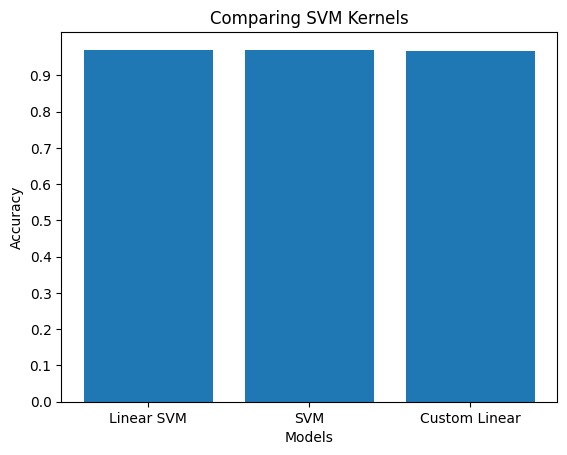

In [100]:
models = ['Linear SVM', 'SVM', "Custom Linear"]
accuracies = [linear_accuracy, nonlinear_accuracy, custom_linear_accuracy]
plt.bar(models, accuracies)
plt.title('Comparing SVM Kernels')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1, step=0.1))

Text(0, 0.5, 'Time to train in seconds')

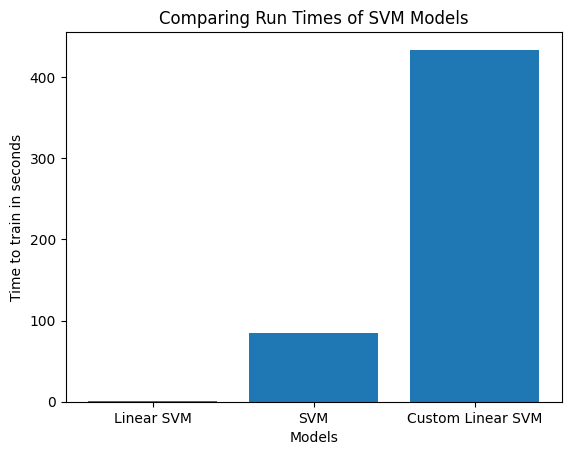

In [102]:
models = ['Linear SVM', 'SVM', "Custom Linear SVM"]
run_times = [1.3731, 84.5488, 433.47]
plt.bar(models, run_times)
plt.title('Comparing Run Times of SVM Models')
plt.xlabel('Models')
plt.ylabel('Time to train in seconds')

In [103]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = LinearSVC(C=0.001)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [104]:
pred_counts = pd.Series(y_pred).value_counts()
print(pred_counts)

Personal Care    485
Accessories      397
Apparel          340
Footwear          95
Name: count, dtype: int64


In [105]:
zero_zero_one = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.9506454062262718


In [106]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = LinearSVC(C=0.01)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [107]:
zero_one = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.9726651480637813


In [108]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = LinearSVC(C=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [109]:
point_one = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.9726651480637813


In [110]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = LinearSVC(C=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\costi\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [111]:
one = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.9688686408504176


In [112]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = LinearSVC(C=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\costi\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [113]:
three = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.9665907365223994


(0.9, 1.0)

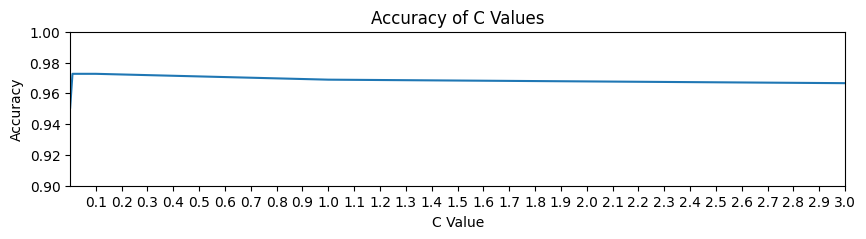

In [114]:
#fig = plt.subplots(figsize=(20, 5))
c_values = [0.001, 0.01, 0.1, 1, 3]
accuracies = [zero_zero_one, zero_one, point_one, one, three]
plt.figure(figsize=(10, 2))
plt.plot(c_values, accuracies)
plt.title('Accuracy of C Values')
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 4, step=0.1)) 
plt.xlim(0.001, 3)
plt.ylim(0.9, 1)

In [115]:
# Classification report
print(classification_report(y_test, y_pred, target_names= styles_df['masterCategory'].unique()))

               precision    recall  f1-score   support

  Accessories       0.93      0.97      0.95       416
      Apparel       0.99      0.99      0.99       344
Personal Care       0.99      0.93      0.96       102
     Footwear       0.41      0.39      0.40        18
   Free Items       1.00      0.98      0.99       437

     accuracy                           0.97      1317
    macro avg       0.86      0.85      0.86      1317
 weighted avg       0.97      0.97      0.97      1317



In [132]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = LinearSVC(C=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [133]:
vectorizer.get_feature_names_out()

array(['0002', '001', '002multifunctional', ..., 'zippersbranding',
       'zircon', 'zone'], dtype=object)

In [134]:
vectorizer.vocabulary_

{'the': 8175,
 'final': 3374,
 'product': 6421,
 'delivered': 2336,
 'might': 5269,
 'vary': 8659,
 'in': 4331,
 'colour': 1742,
 'and': 419,
 'prints': 6404,
 'from': 3700,
 'display': 2661,
 'here': 4140,
 'pack': 5947,
 'of': 5761,
 'two': 8486,
 'red': 6646,
 'briefssoft': 1051,
 'absorbent': 222,
 'fabric': 3241,
 'with': 8963,
 'double': 2726,
 'layer': 4711,
 'contoured': 2003,
 'pouch': 6345,
 'designhigh': 2379,
 'leg': 4751,
 'opening': 5809,
 'full': 3732,
 'back': 632,
 'coveragecomfortable': 2073,
 'covered': 2084,
 'waistband': 8759,
 'spice': 7586,
 'up': 8560,
 'your': 9066,
 'style': 7839,
 'this': 8202,
 'fashionable': 3291,
 'yet': 9055,
 'spacious': 7549,
 'wallet': 8779,
 'fastrack': 3304,
 'while': 8920,
 'it': 4523,
 'is': 4515,
 'well': 8899,
 'organised': 5844,
 'to': 8284,
 'allow': 367,
 'you': 9061,
 'carry': 1316,
 'lot': 4945,
 'essentials': 3103,
 'conveniently': 2017,
 'looks': 4929,
 'absolutely': 217,
 'fabulous': 3250,
 'any': 447,
 'outfit': 5879,
 '

In [135]:
print(accuracy_score(y_test, y_pred))

0.9726651480637813


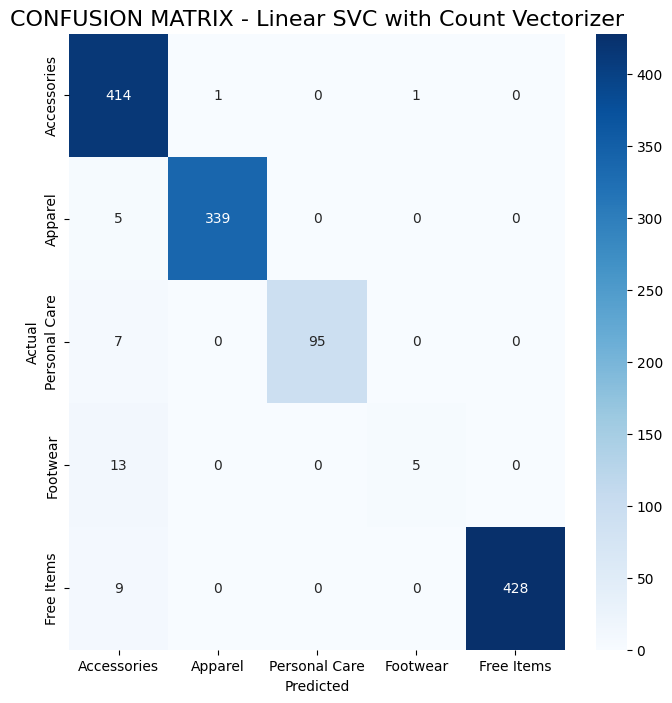

In [136]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.masterCategory.values, 
            yticklabels=category_id_df.masterCategory.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Linear SVC with Count Vectorizer", size=16);

Different Text Classification Strategy
https://www.analyticsvidhya.com/blog/2021/11/a-guide-to-building-an-end-to-end-multiclass-text-classification-model/

In [137]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')
# We transform each description into a vector
features = tfidf.fit_transform(styles_df['description']).toarray()
labels = styles_df['category_id']
print("Each of the %d descriptions is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 6581 descriptions is represented by 13914 features (TF-IDF score of unigrams and bigrams)


In [138]:
# Finding the three most correlated terms with each of the product categories
N = 3
for masterCategory, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("n==> %s:" %(masterCategory))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

n==> Accessories:
  * Most Correlated Unigrams are: dial, steel, case
  * Most Correlated Bigrams are: case style, screw reset, stainless steel
n==> Apparel:
  * Most Correlated Unigrams are: printed, cotton, waistband
  * Most Correlated Bigrams are: colour prints, double layered, elasticated waistband
n==> Footwear:
  * Most Correlated Unigrams are: upper, heel, outsole
  * Most Correlated Bigrams are: store direct, red tape, leather upper
n==> Free Items:
  * Most Correlated Unigrams are: studded, modeswater, casestrap
  * Most Correlated Bigrams are: claspfeatures stopwatch, arms high, comfort glasses
n==> Personal Care:
  * Most Correlated Unigrams are: away, near, spray
  * Most Correlated Bigrams are: aerosol spray, use near, near flame


In [139]:
X_train, X_test, y_train, y_test = train_test_split(styles_df['description'], styles_df['masterCategory'], test_size=0.2, random_state = 42)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors_train = fitted_vectorizer.transform(X_train)
tfidf_vectorizer_vectors_test = fitted_vectorizer.transform(X_test)

model = LinearSVC().fit(tfidf_vectorizer_vectors_train, y_train)
y_pred = model.predict(tfidf_vectorizer_vectors_test)

In [140]:
pred_counts = pd.Series(y_pred).value_counts()
print(pred_counts)

Accessories      451
Personal Care    434
Apparel          331
Footwear          96
Free Items         5
Name: count, dtype: int64


In [141]:
#tfidf_vectorizer_vectors_train.sum().sort_values(ascending=False)

In [142]:
print(accuracy_score(y_test, y_pred))

0.9810174639331815


In [143]:
# Classification report
print(classification_report(y_test, y_pred, target_names= styles_df['masterCategory'].unique()))

               precision    recall  f1-score   support

  Accessories       0.95      1.00      0.97       428
      Apparel       1.00      0.98      0.99       338
Personal Care       1.00      0.94      0.97       102
     Footwear       1.00      0.33      0.50        15
   Free Items       1.00      1.00      1.00       434

     accuracy                           0.98      1317
    macro avg       0.99      0.85      0.89      1317
 weighted avg       0.98      0.98      0.98      1317



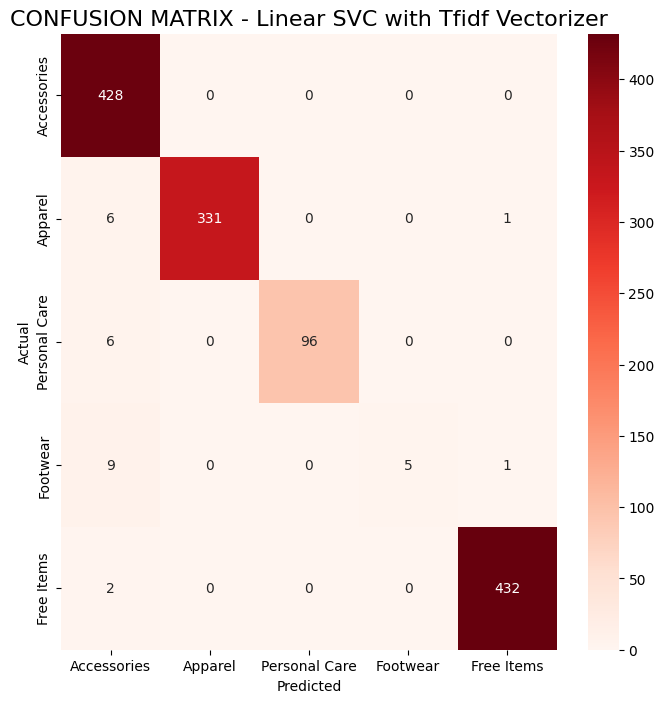

In [144]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Reds", fmt='d',
            xticklabels=category_id_df.masterCategory.values, 
            yticklabels=category_id_df.masterCategory.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Linear SVC with Tfidf Vectorizer", size=16);

Count Vectorizer with Stop Words

In [145]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer(stop_words=stop_words)
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = LinearSVC(C=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

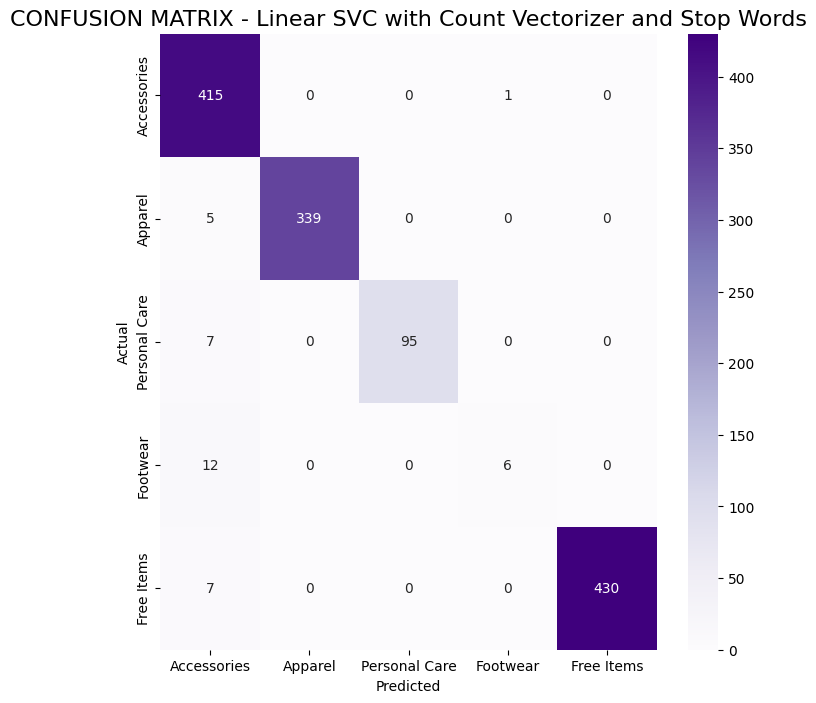

In [146]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Purples", fmt='d',
            xticklabels=category_id_df.masterCategory.values, 
            yticklabels=category_id_df.masterCategory.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Linear SVC with Count Vectorizer and Stop Words", size=16);

In [147]:
print(accuracy_score(y_test, y_pred))

0.9757023538344722


In [148]:
print(y_pred)

['Apparel' 'Accessories' 'Accessories' ... 'Apparel' 'Apparel'
 'Accessories']


In [158]:
X_train.head()

,0002,001,002multifunctional,002pack,002what,003uniquely,003waterproof,003what,004grey,004what,...,zingy,zip,zipped,zippedfour,zipper,zippered,zippers,zippersbranding,zircon,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
